# House Prices

Initilize project files and libraries

In [238]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

data: pd.DataFrame = pd.read_csv("data/train.csv")
test: pd.DataFrame = pd.read_csv("data/test.csv")
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Process data

In [239]:
IdColumn = test[['Id']]          # Save Id column
data = data.drop(columns=['Id']) # We don't need Id for calculations
test = test.drop(columns=['Id'])
data.shape

(1460, 80)

In [240]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

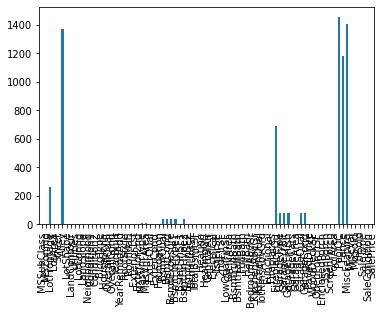

In [241]:
nulls = data.isnull().sum()

ax = nulls.plot.bar()

We can see, that some of the collums are mostly filled with null values.

I will drop the collums that have more than 50% of the values set to null, and changing other collumns' null values either with mean (for numeric data) or mode (for objets)

In [242]:
def handleNullValues(data: pd.DataFrame) -> pd.DataFrame:
    for column in data.columns:
        if data[column].isnull().sum() == 0:
            continue                                                       # No problem with the data, no modification

        elif data[column].isnull().sum() >= data.shape[0] / 2:
            data = data.drop(columns=[column])                             # At least 50% of the data is undefined 

        elif data[column].dtype != np.object_:
            data[column] = data[column].fillna(data[column].mean())        # Numerical types

        else:
            data[column] = data[column].fillna(data[column].mode()[0])     # Object types

    return data

(1460, 76)

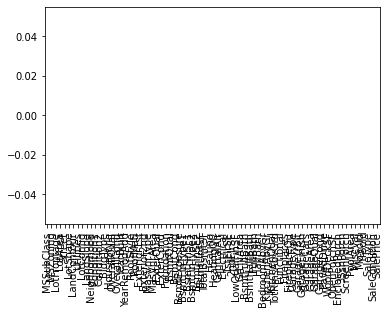

In [243]:
data = handleNullValues(data)
test = handleNullValues(test)

ax = data.isnull().sum().plot.bar()
data.shape

Null values are completely gone.

Now we need to change non-numerical values into numericals using hot_one_encoding

In [244]:
def oneHotEncoder(data: pd.DataFrame) -> pd.DataFrame:
    data_copy: pd.DataFrame = data                                  # We do not want to change data while iterating over it

    for column in data.columns:
        if data[column].dtype != np.object_:
            continue

        dummy = pd.get_dummies(data[column], drop_first=True)

        data_copy = data_copy.drop([column], axis=1)                # We don't need non-numeric column any more
        data_copy = pd.concat([data_copy, dummy], axis=1)       

    data = data_copy
    
    return data

In [245]:
data = oneHotEncoder(data)
test = oneHotEncoder(test)

data = data.loc[:, ~data.columns.duplicated()]      # Remove duplicate collumns
test = test.iloc[:, ~test.columns.duplicated()]

In [246]:
data.info()
data.shape, test.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 177 entries, MSSubClass to Partial
dtypes: float64(3), int64(34), uint8(140)
memory usage: 621.8 KB


((1460, 177), (1459, 166))

train and test datas do not have the same amount of columns.

We need to drop the extra columns from test data and add columns with the value of 0 from train data to test data.

In [247]:
def modifyTestCollumns(train: pd.DataFrame, test: pd.DataFrame) -> pd.DataFrame:              
    test_copy = test                                                 # We should not change the data while iterating over them

    for testColumn in test:
        if testColumn not in train.columns:
            test_copy = test_copy.drop(columns=[testColumn])        # Remove extra columns

    for trainColumn in train:
        if trainColumn not in test and trainColumn != 'SalePrice':  # Test data does not need target column
            test_copy[trainColumn] = 0                              # Add missing columns with the value of 0

    test_sorted = pd.DataFrame()                                    # Sort test columns like train data
    for trainColumn in train:
        if trainColumn != 'SalePrice':
            test_sorted = pd.concat([test_sorted, test_copy[[trainColumn]]], axis=1)

    test = test_sorted

    return test    

In [248]:
test = modifyTestCollumns(data, test)
data.shape, test.shape

((1460, 177), (1459, 176))

all non-nmerical data is gone and the data is ready to be passed to ML model.

### finish up preprocessing and extract information for ML Models

In [249]:
numTrain: int = int(data.shape[0] * 0.8)                            # 80% of the data will be used for training, 20% will be used for validation

yTrain: pd.DataFrame = data[['SalePrice']].iloc[ : numTrain, :]     # SalePrice is our target variable
yValid: pd.DataFrame = data[['SalePrice']].iloc[numTrain : , :]

XTrain: pd.DataFrame = data.drop(columns=['SalePrice']).iloc[ : numTrain, :]
XValid: pd.DataFrame = data.drop(columns=['SalePrice']).iloc[numTrain : , :]

XTrain = (XTrain - XTrain.mean()) / XTrain.std()                    # Feature scaling
XTrain = XTrain.fillna(0)                   # For columns with only 0 values, test.std() is zero, so the values become NaN. Se need to replace them with 0
XValid = (XValid - XValid.mean()) / XValid.std()
XValid = XValid.fillna(0)

test = (test - test.mean()) / test.std()
test = test.fillna(0)

XTrain.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,ConLI,ConLw,New,Oth,WD,AdjLand,Alloca,Family,Normal,Partial
0,0.076049,-0.233046,-0.193993,0.652363,-0.505995,1.053322,0.874813,0.510512,0.605512,-0.287315,...,-0.06554,-0.058596,-0.304188,-0.041398,0.39968,-0.058596,-0.097464,-0.121479,0.477478,-0.309197
1,-0.865143,0.470999,-0.086301,-0.073313,2.168222,0.151871,-0.440033,-0.575434,1.229192,-0.287315,...,-0.06554,-0.058596,-0.304188,-0.041398,0.39968,-0.058596,-0.097464,-0.121479,0.477478,-0.309197
2,0.076049,-0.092237,0.068213,0.652363,-0.505995,0.986548,0.826115,0.322134,0.101066,-0.287315,...,-0.06554,-0.058596,-0.304188,-0.041398,0.39968,-0.058596,-0.097464,-0.121479,0.477478,-0.309197
3,0.311347,-0.467727,-0.090984,0.652363,-0.505995,-1.884741,-0.732221,-0.575434,-0.518027,-0.287315,...,-0.06554,-0.058596,-0.304188,-0.041398,0.39968,-0.058596,-0.097464,-0.121479,-2.092543,-0.309197
4,0.076049,0.658744,0.350085,1.378039,-0.505995,0.953161,0.728719,1.363756,0.488573,-0.287315,...,-0.06554,-0.058596,-0.304188,-0.041398,0.39968,-0.058596,-0.097464,-0.121479,0.477478,-0.309197


In [250]:
test.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,ConLI,ConLw,New,Oth,WD,AdjLand,Alloca,Family,Normal,Partial
0,-0.874411,0.555397,0.363804,-0.750844,0.400629,-0.340828,-1.072517,-0.569913,0.063273,0.517171,...,-0.052414,-0.045377,-0.295167,-0.052414,0.398431,-0.074227,-0.091035,-0.134653,0.460053,-0.299262
1,-0.874411,0.604032,0.897553,-0.054858,0.400629,-0.439544,-1.214492,0.041259,1.063027,-0.297800,...,-0.052414,-0.045377,-0.295167,-0.052414,0.398431,-0.074227,-0.091035,-0.134653,0.460053,-0.299262
2,0.061330,0.263586,0.809368,-0.750844,-0.497247,0.843770,0.678509,-0.569913,0.772989,-0.297800,...,-0.052414,-0.045377,-0.295167,-0.052414,0.398431,-0.074227,-0.091035,-0.134653,0.460053,-0.299262
3,0.061330,0.458126,0.032053,-0.054858,0.400629,0.876675,0.678509,-0.456733,0.357706,-0.297800,...,-0.052414,-0.045377,-0.295167,-0.052414,0.398431,-0.074227,-0.091035,-0.134653,0.460053,-0.299262
4,1.464941,-1.244106,-0.971475,1.337113,-0.497247,0.679242,0.394559,-0.569913,-0.387166,-0.297800,...,-0.052414,-0.045377,-0.295167,-0.052414,0.398431,-0.074227,-0.091035,-0.134653,0.460053,-0.299262


change data to matrices for easy mathematical operations in ML models

In [251]:
XTrain = np.matrix(XTrain.values)
XValid = np.matrix(XValid.values)
yTrain = np.matrix(yTrain.values)
yValid = np.matrix(yValid.values)
testX = np.matrix(test.values)

XTrain.shape, yTrain.shape, XValid.shape, yValid.shape

((1168, 176), (1168, 1), (292, 176), (292, 1))

# Start Creating ML Model

### Define some useful functions for modeling

#### Define gradient descent helper functions

Gradient for linear regression
##### Everything is on one line and one function for optimization, avoids copying.

In [260]:
def gradLin(X: np.matrix, y: np.matrix, theta: list[np.matrix], _: list[np.shape], lambd: float) -> tuple[np.matrix, float]:
    X = np.insert(X, 0, values=np.ones(X.shape[0]), axis=1)
    m = X.shape[0]
    
    regTheta = lambd * theta
    regTheta[0, 0] = 0              # we don't need to regularize first theta

            # error
    return (((X.T * ((X * theta.T) - y)).T + regTheta) / m,                                                    # gradient
            # error                                 # regularized thetas
            np.sum(np.square((X * theta.T) - y)) / (2 * m) + np.sum((lambd * np.square(theta).T)[1, :]) / (2 * m))    # cost                          

Batch generator (generator returns a value when needed, it does not create a list)

In [253]:
def getBatch(X: np.matrix, y: np.matrix, batchSize: int) -> tuple[np.matrix, np.matrix]:
    for i in range(int((X.shape[0] - 1) / batchSize) + 1):
        startIndex = i * batchSize
        endIndex = (i + 1) * batchSize if (i + 1) * batchSize < X.shape[0] else X.shape[0]

        yield X[startIndex : endIndex, :], y[startIndex : endIndex, :]

#### Define gradient descent functions

Batch gradient descent without any optimizations

In [303]:
def batchGradientDescent(X: np.matrix, y: np.matrix, thetaShapes: list[tuple], gradFunc, alpha: float, lambd: float, iters: int) -> tuple[np.matrix, np.ndarray]:
    thetaLength: int = 0
    for shape in thetaShapes:
        size: int = 1
        for dim in shape:
            size *= dim
        thetaLength += int(size)

    theta = np.matrix(np.random.rand(thetaLength))
    costs = np.zeros(iters)

    for i in range(iters):
        grad, cost = gradFunc(X, y, theta, thetaShapes, lambd)

        theta = theta - alpha * grad

        costs[i] = cost

        if i > 0 and costs[-2] > costs[-1] and costs[-2] - costs[-1] < 0.001:        # declare convergence
            break 

    return theta, costs  # return cost for debugging

Mini-batch gradient descent without optimizations

In [ ]:
def miniBatchGradientDescent(X: np.matrix, y: np.matrix, gradFunc, alpha: float, lambd: float, iters: int, batchSize: int) -> tuple[np.matrix, np.ndarray]:
    theta = np.matrix(np.random.rand(X.shape[1] + 1))
    costs: list[float] = list()

    for i in range(iters):
        brk = False
        for XBatch, yBatch in getBatch(X, y, batchSize):
            grad, cost = gradFunc(XBatch, yBatch, theta, lambd)
            theta = theta - alpha * grad

            costs.append(cost)

            if i > 0 and costs[-2] > costs[-1] and costs[-2] - costs[-1] < 0.001:       # declare convergence
                brk = True
                break

        if brk: break

    return theta, np.array(costs)

Stochastic gradient descent with Adam optimizer (Unfortunately, runs very slow. Probably bad code)

In [ ]:
def AdamStochasticGradientDescent(X: np.matrix, y: np.matrix, gradFunc, alpha: float, lambd: float, iters: int, beta1: float = 0.9, beta2: float = 0.999) -> tuple[np.matrix, np.ndarray]:
    theta = np.matrix(np.random.rand(X.shape[1] + 1))
    costs: list[float] = list()
    m = np.matrix(np.zeros(X.shape[1] + 1))
    v = np.matrix(np.zeros(X.shape[1] + 1))
    ephsilon = 1e-08

    for i in range(iters):
        brk = False
        for j in range(X.shape[0]):
            grad, cost = gradFunc(X, y, theta, lambd)
            m = beta1 * m + (1 - beta1) * grad
            v = beta2 * v + (1 - beta2) * np.square(grad)

            mHat = m / (1 - np.power(beta1, j + 1))             # j + 1, because j starts at 0, algorithm t start at 1
            vHat = v / (1 - np.power(beta2, j + 1))

            theta = theta - (alpha * mHat) / (np.sqrt(vHat) + ephsilon)

            costs.append(cost)

            if i > 0 and costs[-2] > costs[-1] and costs[-2] - costs[-1] < 0.001 :         # declare convergence
                brk = True
                break 

        if brk: break

    return theta, np.array(costs)

#### Define Neural Network functions

define helper functions for Neural Networks

In [ ]:
def sigmoid(z: np.matrix) -> np.matrix:
    return 1 / (1 + np.exp(-z))

In [ ]:
def sigGrad(z):
    return np.multiply(sigmoid(z), (1 - sigmoid(z)))

In [295]:
# Converts theta from single line to a list of matrixes
def getThetas(thetaLine: np.matrix, thetaShapes: list[tuple]) -> list[np.matrix]:
    iStart = 0
    result: list[np.matrix] = list()

    for shape in thetaShapes:
        iEnd = iStart + shape[0] * shape[1]
        theta = np.matrix(np.reshape(thetaLine[0, iStart : iEnd], shape))
        iStart = iEnd
        result.append(theta)

    return result

define forward propagation for Neural Network

In [297]:
def forwardProp(X: np.matrix, thetaLine: np.matrix, thetaShapes: list[tuple]) -> tuple[list[np.matrix], list[np.matrix], float]:
    thetas = getThetas(thetaLine, thetaShapes)

    m = X.shape[0]
    aValues: list[np.matrix] = list()
    zValues: list[np.matrix] = list()
    
    a: np.matrix = np.insert(X, 0, values=np.ones(m), axis=1)
    aValues.append(a)
    z: np.matrix = np.matrix([])            # init empty to use outside of loop
    for i, theta in enumerate(thetas):
        z = a * theta.T
        
        if i != len(thetas) - 1:             # last a is h, we do not need to add it to the list
            a = np.insert(sigmoid(z), 0, values=np.ones(m), axis=1)
            aValues.append(a)
            
        zValues.append(z)

    h: np.matrix = z                        # We do not need to use sigmoid, because final value is not descrete (its in range [0, +inf))

    return aValues, zValues, h

Define cost function for Neural Networks

In [306]:
def costNN(h: np.matrix, y: np.matrix, thetas: list[np.matrix], lambd: float) -> float:
    m = y.shape[0]

    # compute the cost
    J = np.sum(np.square(h - y)) / (2 * m)           # We only have one node in output layer, with linear activation
    
    # add the cost regularization term
    sqThetaSum = sum(np.sum(np.power(theta[:, 1 : ], 2)) for theta in thetas)
    J += (lambd / (2 * m)) * sqThetaSum

    return J

Define backpropagation function

In [315]:
def backProp(X: np.matrix, y: np.matrix, thetaLine: np.matrix, thetaShapes: list[tuple], lambd: float) -> tuple[float, np.matrix]:
    thetas = getThetas(thetaLine, thetaShapes)
    m = X.shape[0]
    
    # run the feed-forward pass
    aValues, zValues, h = forwardProp(X, thetaLine, thetaShapes)
    
    # initializations
    deltas: list[np.matrix] = list(np.zeros(theta.shape) for theta in thetas)
    
    # compute the cost
    J = costNN(h, y, thetas, lambd)
    
    # perform backpropagation
    deltaL: np.matrix = h - y
    for i in reversed(range(len(deltas))):
        deltas[i] = deltas[i] - deltaL.T * aValues[i]
        if i == 0: continue
        deltaL = np.multiply((deltaL * thetas[i])[:, 1:], sigGrad(zValues[i - 1]))
    
    # add the gradient regularization term
    for i, delta in enumerate(deltas):
        delta[:,1:] = delta[:,1:] + (thetas[i][:,1:] * lambd) / m
    
    # unravel the gradient matrices into a single array
    grad: np.matrix = np.concatenate([np.ravel(delta) for delta in deltas])
    
    return grad, J

In [ ]:
x = np.matrix([[1, 2, 3], [2, 3, 2]])
Y = np.matrix([[2], [3]])
t = [np.matrix([[1, 1, 1, 1], [1, 2, 2, 3]]), np.matrix([[3, 2, 1], [3, 1, 3]]), np.matrix([[4, 4, 2]])]
backProp(x, Y, t, 0.1)

(29.53712036339547,
 [matrix([[2.07506850e-04, 5.02580310e-02, 5.04655378e-02, 5.05719964e-02],
          [1.82360669e-08, 1.00000023e-01, 1.00000041e-01, 1.50000050e-01]]),
  matrix([[0.14794824, 0.24785317, 0.19794823],
          [0.02728144, 0.07726391, 0.17728144]]),
  matrix([[14.97654793, 15.13946906, 15.06289476]])])

# Train models
#### Train linear regression models

Training takes roughly 5 minutes, comment out AdamSGD to run this part quickly

In [274]:
models: list[tuple[np.matrix, np.ndarray, float]] = list()
iters = 5000
linearTheta = [tuple([XTrain.shape[1] + 1])]

# Add models to the list
for i in range(6):                                                          # from 0.001 to about 0.3
    alpha: float = 0.001 * (3 ** i)
    theta, cost = batchGradientDescent(XTrain, yTrain, linearTheta, gradLin, alpha, 0.1, iters)
    models.append((theta, cost, 0.1))                                # add cost to check later if it is the model worked correctly

    # theta, cost = miniBatchGradientDescent(XTrain, yTrain, gradLin, alpha, 0.1, 1000, 100)
    # models.append((theta, cost, 0.1))

# theta, cost = AdamStochasticGradientDescent(XTrain, yTrain, gradLin, 0.01, 0.1, 500)    # it is very slow in the loop
# models.append((theta, cost, 0.1))

/opt/anaconda3/envs/Freeuni_ML/lib/python3.9/site-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/var/folders/cg/nbkqfqq15tb9bkp7kghtnggm0000gp/T/ipykernel_990/192966440.py:11: RuntimeWarning: overflow encountered in square
  np.sum(np.square((X * theta.T) - y)) / (2 * m) + np.sum((lambd * np.square(theta).T)[1, :]) / (2 * m))    # cost


#### Train Neural Networks

In [318]:
# NN with 3 Hidden layers of sizes (trainData/2, trainData/16, 8)
dataShape = XTrain.shape
NNThetaShapes = [(int(dataShape[0] / 2), XTrain.shape[1] + 1), (int(dataShape[0] / 16), int(dataShape[0] / 2) + 1), (8, int(dataShape[0] / 16) + 1), (1, 9)]
NNThetas, NNCost = batchGradientDescent(XTrain, yTrain, NNThetaShapes, backProp, 0.01, 0.01, 100)

/var/folders/cg/nbkqfqq15tb9bkp7kghtnggm0000gp/T/ipykernel_990/578850080.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/opt/anaconda3/envs/Freeuni_ML/lib/python3.9/site-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/var/folders/cg/nbkqfqq15tb9bkp7kghtnggm0000gp/T/ipykernel_990/2212277603.py:5: RuntimeWarning: overflow encountered in square
  J = np.sum(np.square(h - y)) / (2 * m)           # We only have one node in output layer, with linear activation
/var/folders/cg/nbkqfqq15tb9bkp7kghtnggm0000gp/T/ipykernel_990/2212277603.py:8: RuntimeWarning: overflow encountered in power
  sqThetaSum = sum(np.sum(np.power(theta[:, 1 : ], 2)) for theta in thetas)
/var/folders/cg/nbkqfqq15tb9bkp7kghtnggm0000gp/T/ipykernel_990/1151356968.py:19: RuntimeWarning: invalid value encountered in multiply
  deltaL = np.multiply((deltaL * thetas[i])[:, 1:], sigGrad(zValues[i -

# Test Model

#### Choose least cost model with validation data

In [316]:
theta, cost, lambd = min(models, key=lambda x: gradLin(XValid, yValid, x[0], linearTheta, x[2])[1])
theta.shape, cost[-1], gradLin(XValid, yValid, theta, linearTheta, lambd)[1]

((1, 177), 266514921.95853922, 1012172201.2942365)

Text(0.5, 1.0, 'Error vs. Training Epoch')

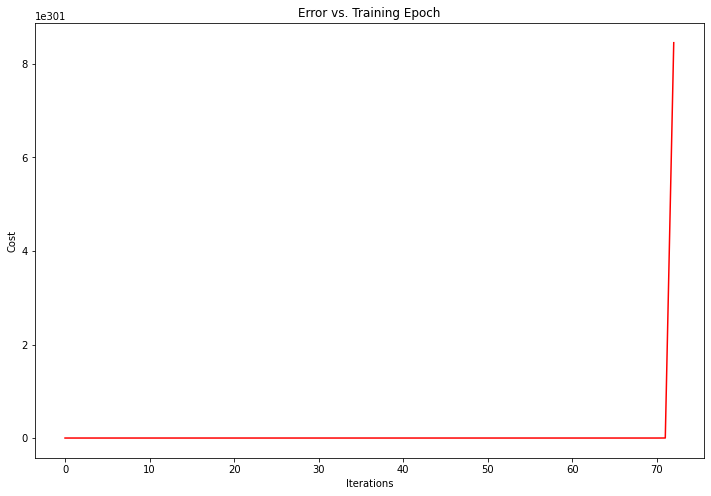

In [319]:
vfig, ax = plt.subplots(figsize=(12,8))
ax.plot(np.arange(NNCost.size), NNCost, 'r')
ax.set_xlabel('Iterations')
ax.set_ylabel('Cost')
ax.set_title('Error vs. Training Epoch')

The model we choose works correctly, cost is constantly lowering in value
#### Graph validation data to check how well the model predected
Compare actual results to the predicted ones

/var/folders/cg/nbkqfqq15tb9bkp7kghtnggm0000gp/T/ipykernel_990/578850080.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/opt/anaconda3/envs/Freeuni_ML/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


ValueError: setting an array element with a sequence.

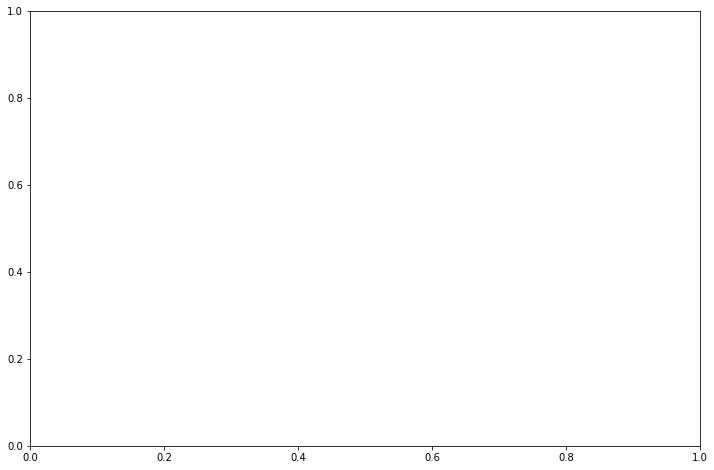

In [314]:
pred = theta[0, 0] + (XValid * theta[0, 1 : ].T)

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(pred, pred, 'r', label='Perfect prediction line')             # perfect prediction would be if predicted values where equal to real values
ax.scatter(pred.tolist(), yValid[:, -1].tolist())
ax.legend(loc=2)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title(f'Predicted Price vs. Actual Price')

Linear regression algorithm works mostly correctly. It's predictions are very close to the real values (with only a few exceptions, from what we can see on graph)

# Predict final test data

In [ ]:
test_with_ones = np.insert(testX, 0, np.ones(testX.shape[0]), axis=1)
pred = test_with_ones * theta.T
result = pd.DataFrame(pred, columns=['SalePrice'])
result = pd.concat([IdColumn, result], axis=1)

result.head()
result.to_csv('data/result.csv', index=False)